In [1]:
%matplotlib inline  

from os.path import isfile, join, exists
from os import listdir, makedirs, walk, remove, getlogin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from nilearn import image, masking
import scipy.stats as stats
import os
import numpy as np
import pickle
import librosa

/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# exp params
projdir = '/mnt/bucket/labs/hasson/mai/projects/b2b_teaching'
    
run_list = ['teach1_epi_lesson1', 'teach2_epi_lesson2', 'teach2_epi_lesson3', 'teach3_epi_lesson4', 'teach3_epi_lesson5']

roi_list = ['julich_A1_TE1_both_bin20_3mm', 'v1_recent_25ss_3mm', 'sherlockAvg_fc_thr5_lSFG_3mm', 
            'sherlockAvg_fc_thr5_rSFG_3mm', 'sherlockAvg_fc_thr5_lTPJ_3mm', 'sherlockAvg_fc_thr5_rTPJ_3mm', 
            'sherlockAvg_fc_thr5_mpfc_3mm', 'sherlockAvg_fc_thr5_pmc_3mm']

hrf = 3

In [3]:
# get time stamps
x1 = pd.ExcelFile(join(projdir, 'recordings', 'lesson_timestamps.xlsx'))
df_times = x1.parse('times')

df_times = df_times.drop([0])
timestamps = {};
for i,run in enumerate(run_list):
    trs = df_times['tr' + str(i+1)]
    timestamps[run] = trs.tolist()

for run in run_list:
    times = timestamps[run]
    for i in range(len(times)-1):
        this_time = times[i]
        next_time = times[i+1]
        if next_time <= this_time:
            print('out of order: run ' + run + ', ind ' + str(i) + ', tr ' + str(times[i]))



In [4]:

for roi in roi_list:
    print(roi)
    
    # load datafile
    datafile = join(projdir, 'teach_data', 'data', 'roidata', roi + '_teachData.pk1')
    pkl_file = open(datafile, 'rb')
    roidict = pickle.load(pkl_file)
    pkl_file.close()

    eventdict = {}
    for run in run_list:
        # get data for this run
        roidata = roidict[run]
        times = timestamps[run]

        # get data within each event
        events = [];
        for i in range(len(times)):
            start = int(times[i]) + hrf
            if i == len(times)-1:
                stop = roidata.shape[1]
            else:
                stop = int(times[i+1]) + hrf
            ev = roidata[:, start:stop]
            events.append(ev)
        eventdict[run] = events

    # savedata
    datadict = {'data': eventdict, 'times': times, 'origdata': datafile, 'runs': run_list, 'roi':roi, 'hrf': hrf}
    savename = join(projdir, 'teach_data', 'data', 'roidata', roi + '_events_hrf' + str(hrf) + '.pk1')
    f = open(savename,"wb")
    pickle.dump(datadict,f)
    f.close()

julich_A1_TE1_both_bin20_3mm
v1_recent_25ss_3mm
sherlockAvg_fc_thr5_lSFG_3mm
sherlockAvg_fc_thr5_rSFG_3mm
sherlockAvg_fc_thr5_lTPJ_3mm
sherlockAvg_fc_thr5_rTPJ_3mm
sherlockAvg_fc_thr5_mpfc_3mm
sherlockAvg_fc_thr5_pmc_3mm


In [10]:
# model = 2
# model_epi = 'teach2_epi_lesson3'

# datafile = join(projdir, 'teach_data', 'data', 'roidata', roi + '_events_hrf' + str(hrf) + '.pk1')
# pkl_file = open(datafile, 'rb')
# roidict = pickle.load(pkl_file)
# pkl_file.close()

# roidata = roidict['data']

# for roi in roi_list:
#     # get times
#     trs = []
#     subdata = roidata[model_epi]
#     for ev in subdata:
#         trs.append(ev.shape[1])

In [5]:
# stretch roi data

model = 2
model_epi = 'teach2_epi_lesson3'


# load
for roi in roi_list:
    print(roi)
    
    datafile = join(projdir, 'teach_data', 'data', 'roidata', roi + '_events_hrf' + str(hrf) + '.pk1')
    pkl_file = open(datafile, 'rb')
    roidict = pickle.load(pkl_file)
    pkl_file.close()

    roidata = roidict['data']

    # get times
    trs = []
    subdata = roidata[model_epi]
    for ev in subdata:
        trs.append(ev.shape[1])

    # stretch data
    data_stretch = []
    for run in run_list:
        subdata = roidata[run]
        for i,ev in enumerate(subdata):
            ev_new = librosa.core.resample(ev, ev.shape[1], trs[i])
            if i == 0:
                sub_stretch = ev_new
            else:
                sub_stretch = np.concatenate([sub_stretch, ev_new], axis=1)
        data_stretch.append(sub_stretch)

    # save
    datadict = {'data': data_stretch, 'times': times, 'origdata': datafile, 'runs': run_list, 'roi':roi, 
                'model': model_epi, 'hrf': hrf}

    savename = join(projdir, 'teach_data', 'data', 'roidata', roi + '_events_hrf' + str(hrf) + '_stretch.pk1')
    output = open(savename, 'wb')
    pickle.dump(datadict, output)
    output.close()

julich_A1_TE1_both_bin20_3mm
v1_recent_25ss_3mm
sherlockAvg_fc_thr5_lSFG_3mm
sherlockAvg_fc_thr5_rSFG_3mm
sherlockAvg_fc_thr5_lTPJ_3mm
sherlockAvg_fc_thr5_rTPJ_3mm
sherlockAvg_fc_thr5_mpfc_3mm
sherlockAvg_fc_thr5_pmc_3mm


In [9]:
# isc

r_all = []

for roi in roi_list:
    print(roi)
    # load data
    datafile = join(projdir, 'teach_data', 'data', 'roidata', roi + '_events_hrf' + str(hrf) +  '_stretch.pk1')
    pkl_file = open(datafile, 'rb')
    datadict = pickle.load(pkl_file)
    pkl_file.close()

    roidata = datadict['data']

    # zscore
    roidata_z = []
    for subdata in roidata:
        subdata_z = stats.zscore(subdata, axis=1, ddof=1)
        roidata_z.append(subdata_z)

    # get sum of all
    roidata_sum = np.sum(roidata_z, axis=0)

    # isc
    r_roi = []
    for subdata in roidata:
        # get average of others
        otherdata = (roidata_sum - subdata) / (len(run_list)-1)

        # get average of roi
        subdata_mean = np.nanmean(subdata, axis=0)
        otherdata_mean = np.nanmean(otherdata, axis=0)

        # get corr
        r,p = stats.pearsonr(subdata_mean, otherdata_mean)
        r_roi.append(r)
        
    r_all.append(r_roi)

# save results
iscdict = {'r': r_all, 'rois': roi_list, 'hrf': hrf, 'datafile': datafile}
savename = join(projdir, 'teach_data', 'analysis', 'isc_roi', 'iscResults_rois_hrf' + str(hrf) + '_stretch.pk1')
output = open(savename, 'wb')
pickle.dump(iscdict, output)
output.close()

julich_A1_TE1_both_bin20_3mm
v1_recent_25ss_3mm
sherlockAvg_fc_thr5_lSFG_3mm
sherlockAvg_fc_thr5_rSFG_3mm
sherlockAvg_fc_thr5_lTPJ_3mm
sherlockAvg_fc_thr5_rTPJ_3mm
sherlockAvg_fc_thr5_mpfc_3mm
sherlockAvg_fc_thr5_pmc_3mm


/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


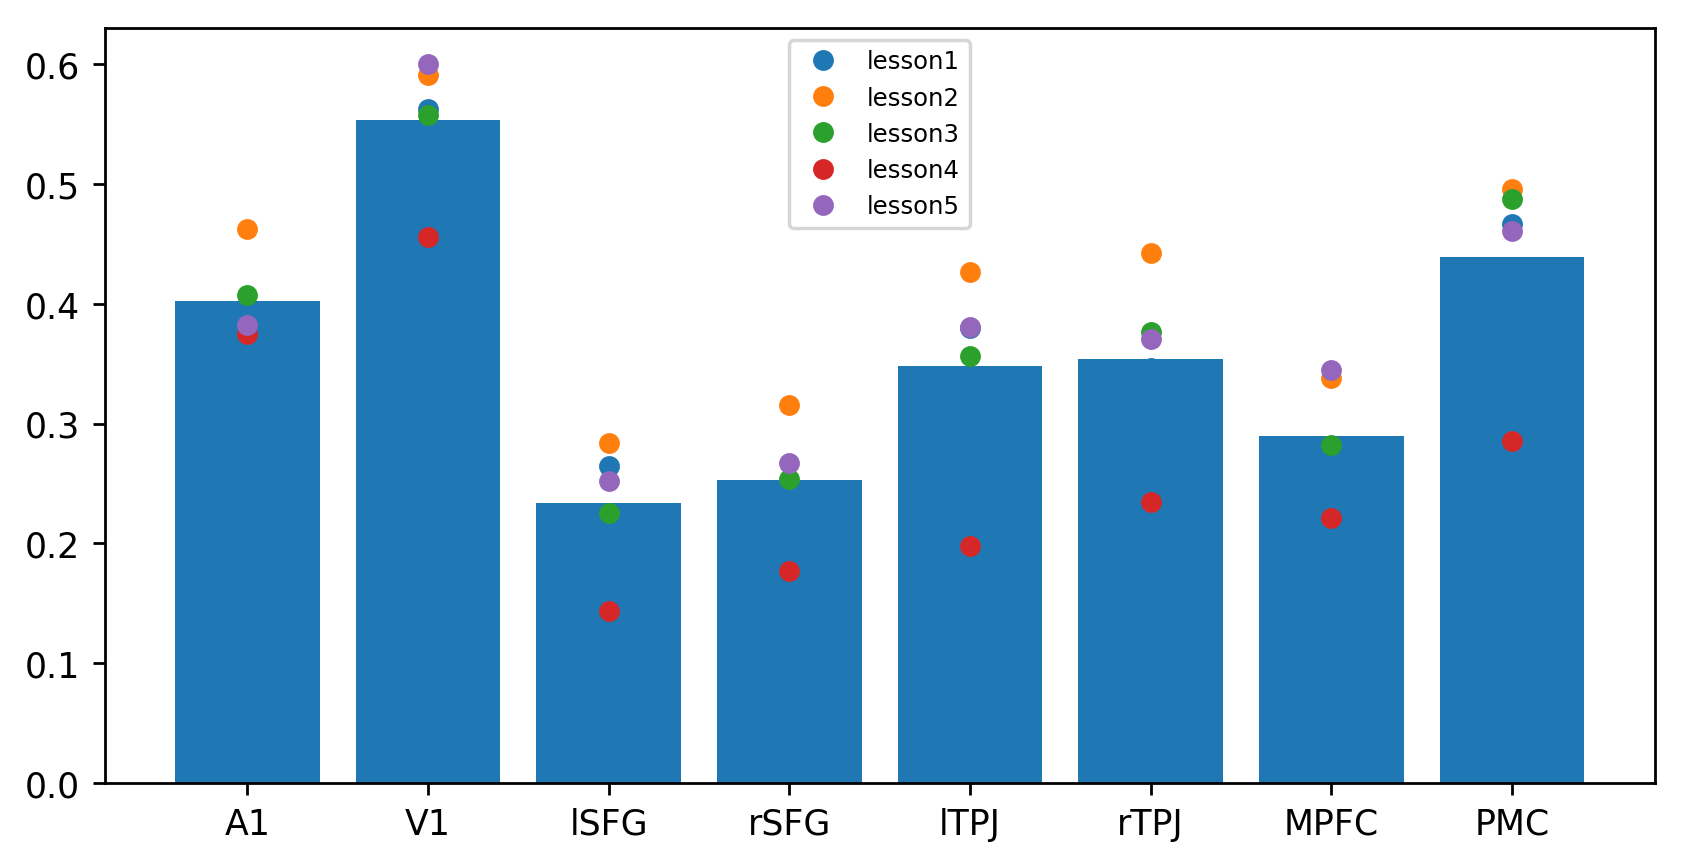

In [6]:
# make some figures
hrf = 0
rois_short = ['A1', 'V1', 'lSFG', 'rSFG', 'lTPJ', 'rTPJ', 'MPFC', 'PMC']
label_list = ['lesson1', 'lesson2', 'lesson3', 'lesson4', 'lesson5']

# load data
iscfile = join(projdir, 'teach_data', 'analysis', 'isc_roi', 'iscResults_rois_hrf' + str(hrf) + '_stretch.pk1')
pkl_file = open(iscfile, 'rb')
iscdict = pickle.load(pkl_file)
pkl_file.close()

# Get results
results = np.asarray(iscdict['r'])
results_mean = np.mean(results,axis=1)

# plot
fig = plt.figure(figsize=(8, 4), dpi= 250, facecolor='w', edgecolor='k')
x = range(len(results_mean))
plt.bar(x, results_mean)
for i in range(len(run_list)):
    plt.plot(results[:,i], '.', markersize=10, label=label_list[i]);
plt.xticks(x, rois_short);
plt.legend(prop={'size': 7})

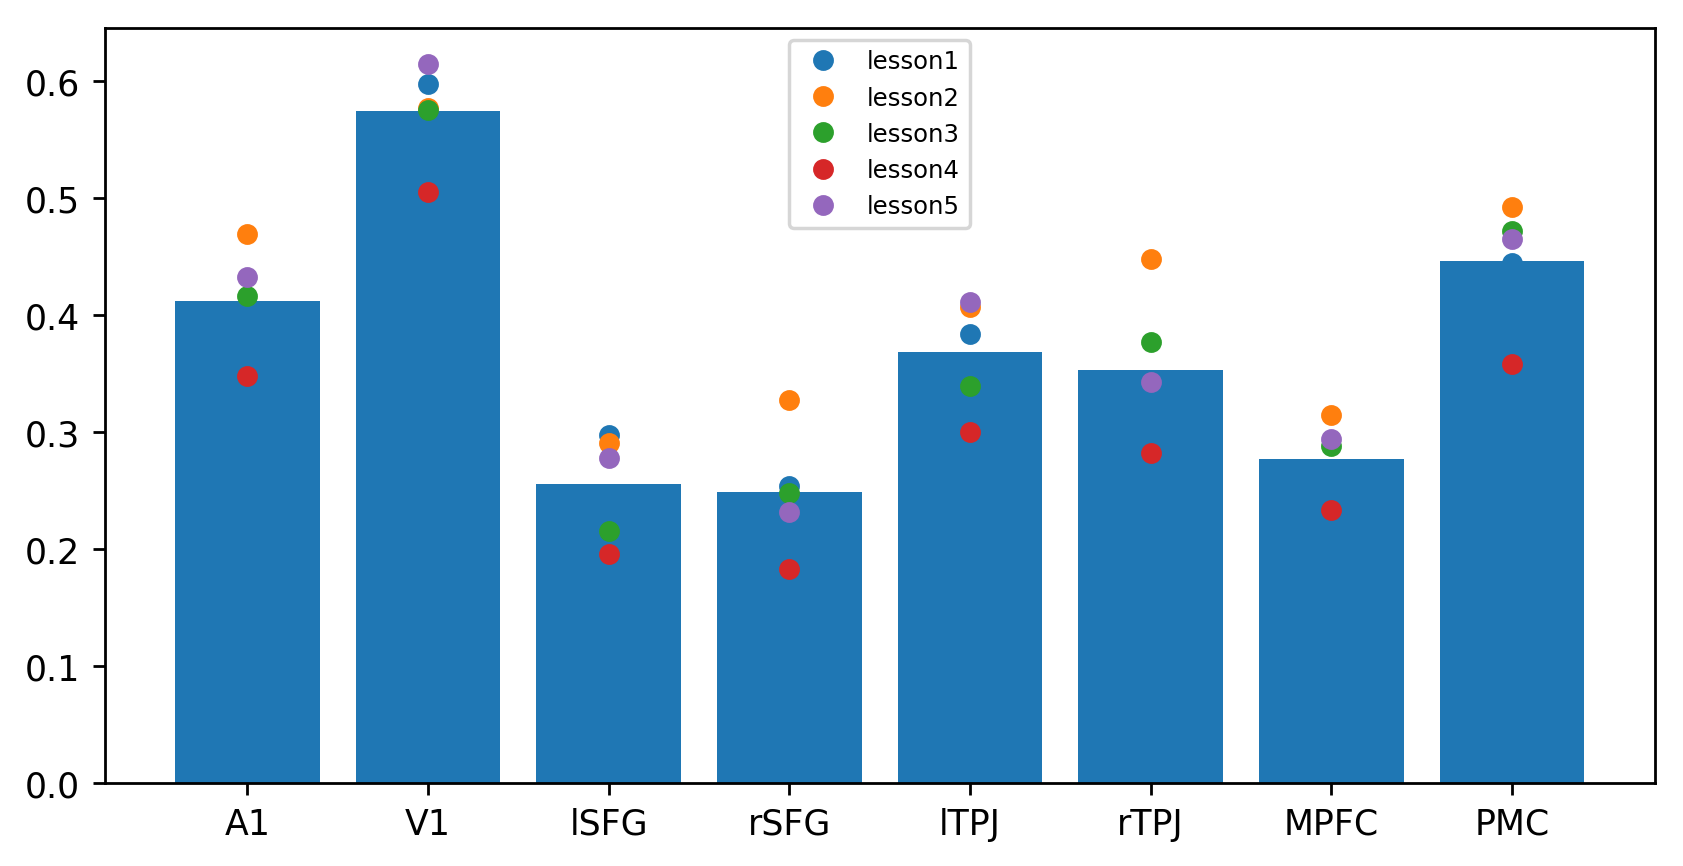

In [5]:
# make some figures
hrf = 3
rois_short = ['A1', 'V1', 'lSFG', 'rSFG', 'lTPJ', 'rTPJ', 'MPFC', 'PMC']
label_list = ['lesson1', 'lesson2', 'lesson3', 'lesson4', 'lesson5']

# load data
iscfile = join(projdir, 'teach_data', 'analysis', 'isc_roi', 'iscResults_rois_hrf' + str(hrf) + '_stretch.pk1')
pkl_file = open(iscfile, 'rb')
iscdict = pickle.load(pkl_file)
pkl_file.close()

# Get results
results = np.asarray(iscdict['r'])
results_mean2 = np.mean(results,axis=1)

# plot
fig = plt.figure(figsize=(8, 4), dpi= 250, facecolor='w', edgecolor='k')
x = range(len(results_mean))
plt.bar(x, results_mean2)
for i in range(len(run_list)):
    plt.plot(results[:,i], '.', markersize=10, label=label_list[i]);
plt.xticks(x, rois_short);
plt.legend(prop={'size': 7})

In [7]:
results_mean

array([0.40208548, 0.55374116, 0.23385295, 0.25253382, 0.34817582,
       0.354054  , 0.28927815, 0.43944302], dtype=float32)

In [8]:
results_mean2

array([0.4121526 , 0.57434714, 0.25551262, 0.24879017, 0.3685061 ,
       0.35332128, 0.27692986, 0.44655722], dtype=float32)